In [4]:
import networkx as nx
import nest_asyncio
import optuna
from optuna.integration import PyTorchLightningPruningCallback
from optuna.visualization import plot_param_importances, plot_contour
import pandas as pd
from plotly.graph_objects import Figure
import lightning.pytorch as pl
from lightning.pytorch.callbacks import EarlyStopping, ModelCheckpoint
from lightning.pytorch.loggers import WandbLogger
from sklearn.preprocessing import LabelEncoder, MaxAbsScaler
import torch
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.utils.convert import from_networkx
import wandb

from modules import dataset, graph, model, paths

In [5]:
# Allows for asyncio to be run in notebooks
nest_asyncio.apply()

# Task 2

## Dataset

In [6]:
# Load the dataset

# Preprocessors
scaler: MaxAbsScaler = MaxAbsScaler()
label_encoder: LabelEncoder = LabelEncoder()

# Prepare the training set
train_set: pd.DataFrame = dataset.get_page_len_dataset('train')
train_x: pd.DataFrame = train_set.drop(columns=['label','description', 'id'])
train_x['num_sitelinks'] = train_set['num_sitelinks']  
train_x = pd.DataFrame(scaler.fit_transform(train_x), columns=train_x.columns)
train_x = train_x.fillna(0)
train_sitelinks = train_set['num_sitelinks'].fillna(0).tolist()


train_y: torch.Tensor = torch.tensor(label_encoder.fit_transform(train_set['label']))

# Prepare the validation set
valid_set: pd.DataFrame = dataset.get_page_len_dataset('valid')
valid_x: pd.DataFrame = valid_set.drop(columns=['label','description','id']).reindex(columns=train_x.columns)
valid_x['num_sitelinks'] = valid_set['num_sitelinks'] 
valid_x = pd.DataFrame(scaler.transform(valid_x), columns=valid_x.columns)
valid_x = valid_x.fillna(0)
valid_sitelinks = valid_set['num_sitelinks'].fillna(0).tolist()
valid_y: torch.Tensor = torch.tensor(label_encoder.transform(valid_set['label']))



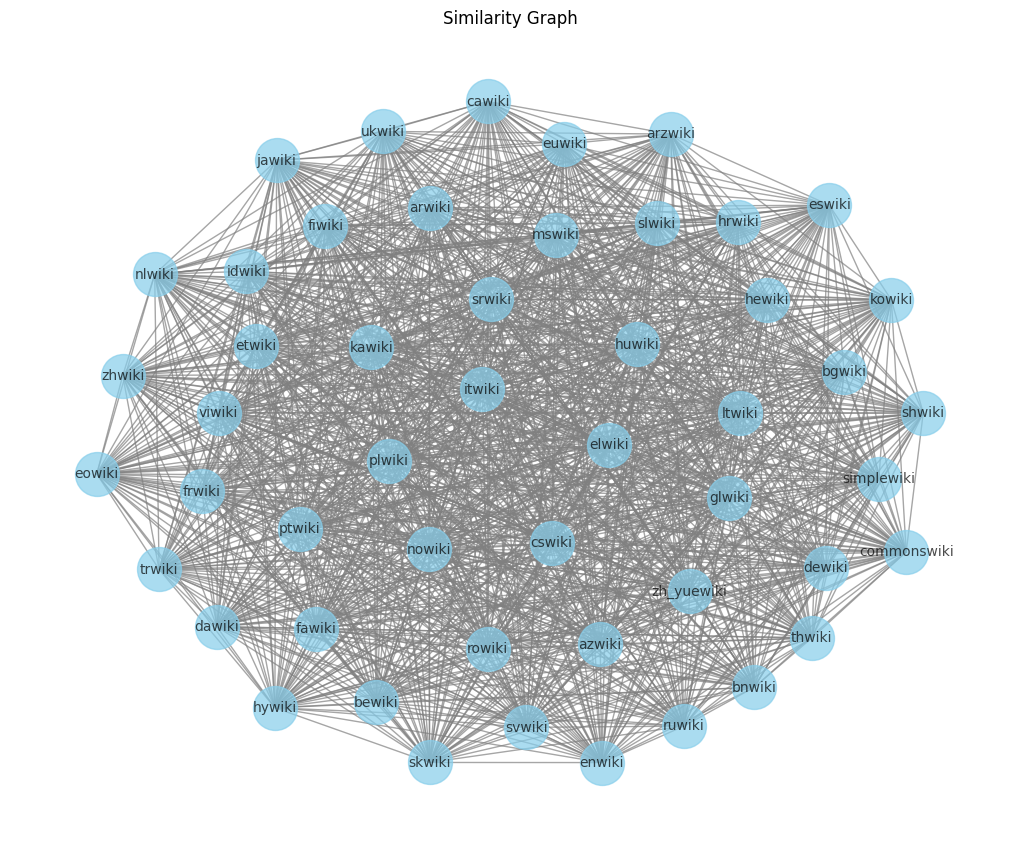

In [7]:
# Create the graphs

similarity_graph: graph.SimilarityGraph = graph.SimilarityGraph(train_x.drop(columns=['num_sitelinks']), threshold = 0.5, min_arity = 2, show = True)

training_graphs: list[nx.Graph] = similarity_graph.get_graphs(train_x, global_features=train_sitelinks)
validation_graphs: list[nx.Graph] = similarity_graph.get_graphs(valid_x, global_features=valid_sitelinks)

In [8]:
# Make the graphs compatible with PyTorch Geometric (con debug prints)

train_data: list[Data] = []
for idx, (digraph, label) in enumerate(zip(training_graphs, train_y)):
    x_list = [digraph.nodes[n]['x'] for n in digraph.nodes]
    data = from_networkx(digraph, group_node_attrs=['x'])
    data.x = torch.tensor(x_list, dtype=torch.float)
    data.y = label
    train_data.append(data)

valid_data: list[Data] = []
for idx, (digraph, label) in enumerate(zip(validation_graphs, valid_y)):
    x_list = [digraph.nodes[n]['x'] for n in digraph.nodes]
    data = from_networkx(digraph, group_node_attrs=['x'])
    data.x = torch.tensor(x_list, dtype=torch.float)
    data.y = label
    valid_data.append(data)


## Model

### Hyperparameter tuning

In [9]:
def objective(trial: optuna.Trial) -> float:
    # Hyperparameters
    hidden_dim: int = trial.suggest_int('hidden_dim', 32, 256, step=32)
    lr: float        = trial.suggest_float('lr', 1e-5, 1e-1, log=True)
    dropout: float   = trial.suggest_float('dropout', 0., 0.5)

    # Data loaders
    train_loader = DataLoader(train_data, batch_size=256, shuffle=True)
    valid_loader = DataLoader(valid_data, batch_size=256)

    # Model & callbacks
    gcn = model.GCN(hidden_dim, lr=lr, dropout=dropout)
    early_stopping = EarlyStopping(monitor='val_loss', patience=10)
    pruning_cb = PyTorchLightningPruningCallback(trial, monitor='val_loss')

    trainer = pl.Trainer(
        max_epochs=50,  # assicurati > 0
        callbacks=[early_stopping, pruning_cb],
        logger=False,
        enable_progress_bar=False,
        enable_model_summary=False,
        enable_checkpointing=False,
        precision='16-mixed'
    )

    trainer.fit(gcn, train_loader, valid_loader)

    pruning_cb.check_pruned()

    metrics = trainer.validate(gcn, valid_loader, verbose=False)

    if not metrics or 'val_f1' not in metrics[0]:
        raise RuntimeError(f"[Trial {trial.number}] Missing 'val_f1' in {metrics[0].keys()}")
    f1 = float(metrics[0]['val_f1'])
    return f1


In [10]:
# Optuna study
study: optuna.Study = optuna.create_study(direction = 'maximize', pruner = optuna.pruners.MedianPruner(n_warmup_steps = 10))
study.optimize(objective, n_trials = 10, n_jobs = -1)

[I 2025-04-20 18:03:06,387] A new study created in memory with name: no-name-8a3f6dae-d3f3-4741-9987-4d591d203212
Using 16bit Automatic Mixed Precision (AMP)
Using 16bit Automatic Mixed Precision (AMP)
Using 16bit Automatic Mixed Precision (AMP)
Using 16bit Automatic Mixed Precision (AMP)
Using 16bit Automatic Mixed Precision (AMP)
Using 16bit Automatic Mixed Precision (AMP)
Using 16bit Automatic Mixed Precision (AMP)
Using 16bit Automatic Mixed Precision (AMP)
Using 16bit Automatic Mixed Precision (AMP)
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
GPU available: True (cuda), used: True
GPU available: True (cuda), used: True
GPU available: True (cuda), used: True
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
TPU available: False, using: 0 TPU cores
GPU available: True (cuda), used: True
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
GPU available: True (cuda), used: True
TPU availab

In [11]:
# Plot parameter importances
param_importances_fig: Figure = plot_param_importances(study)
param_fig: Figure = plot_param_importances(study)
param_fig.update_layout(autosize = False,
                        width = 1200,
                        height = 400
                        )
param_fig.show()

# Plot contour
contour_fig: Figure = plot_contour(study)
contour_fig.update_layout(autosize = False,
                          width = 1200,
                          height = 1200
                          )
contour_fig.show()

### Best Model

In [12]:
# Take the best hyperparameters and print them
best_params: dict[str, int|float] = study.best_trial.params

# Retrain the model with the best hyperparameters
best_hidden_dim: int = int(best_params['hidden_dim'])
best_lr: float = best_params['lr']
best_dropout: float = best_params['dropout']

print(f"Best hyperparameters:\n\thidden dimension: {best_hidden_dim}\n\tlearning rate: {best_lr:.3e}\n\tdropout: {best_dropout:.3e}")

Best hyperparameters:
	hidden dimension: 32
	learning rate: 8.685e-05
	dropout: 3.450e-01


In [13]:
# Retrain the model with the best hyperparameters

# Data loaders
train_loader: DataLoader = DataLoader(train_data,
                                      batch_size = 256,
                                      shuffle = True
                                      )
valid_loader: DataLoader = DataLoader(valid_data,
                                      batch_size = 256
                                      )

# Model
gcn: model.GCN = model.GCN(best_hidden_dim, lr = best_lr, dropout = best_dropout)

# Wandb logger
wandb_logger: WandbLogger = WandbLogger(project = 'MNLP_HW_1', name = 'best_model', save_dir = paths.DATA_DIR)

# Callbacks
early_stopping: EarlyStopping = EarlyStopping(monitor='val_loss', patience = 10)
checkpoint: ModelCheckpoint = ModelCheckpoint(monitor='val_loss')

# Trainer
trainer: pl.Trainer = pl.Trainer(max_epochs = -1,
                                 callbacks = [early_stopping, checkpoint],
                                 logger = wandb_logger,
                                 log_every_n_steps = len(train_loader)
                                 )

# Train the model
trainer.fit(gcn, train_loader, valid_loader)

# Close wandb and remove the logger from the trainer
trainer.logger = None
wandb.finish()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: urbini-2007465 (urbini-2007465-sapienza-universit-di-roma) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name            | Type                | Params | Mode 
-----------------------------------------------------------------
0  | conv1           | GCNConv             | 96     | train
1  | norm1           | GraphNorm           | 96     | train
2  | conv2           | GCNConv             | 1.1 K  | train
3  | norm2           | GraphNorm           | 96     | train
4  | fc              | Linear              | 99     | train
5  | dropout         | Dropout             | 0      | train
6  | train_loss      | CrossEntropyLoss    | 0      | train
7  | val_loss        | CrossEntropyLoss    | 0      | train
8  | train_accuracy  | MulticlassAccuracy  | 0      | train
9  | val_accuracy    | MulticlassAccuracy  | 0      | train
10 | train_f1        | MulticlassF1Score   | 0      | train
11 | val_f1          | MulticlassF1Score   | 0      | train
12 | train_precision | MulticlassPrecision | 0      | train
13 | val_precision   | MulticlassPrecision | 0     

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

C:\Users\fedur\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: PossibleUserWarning:

The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.

C:\Users\fedur\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: PossibleUserWarning:

The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.



Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████
train_accuracy,▅▄▆▃▆▅▄▄▂▆▆▁▆▄▄▇▅▅▆▇▆▄▄▅█▅▆▇▅▆▃▅
train_f1,▆▂▇▂▆▆▃▂▄▅▆▁▆▄▅█▆▅▆█▆▃▄▇█▇██▇▇▄▇
train_loss,▆█▃▆▄▃▆▆▆▄▆▅▃█▆▃▃▄▄▄▆▇█▁▁▃▃▁▃▆█▃
train_precision,▄▅▇▅█▅▅▃▃▆▄▁▄▃▃▆▆▂▄▅▅▂▂▄▅▄▄▆▅▆▂▅
train_recall,▅▄▆▃▆▅▄▄▂▆▆▁▆▄▄▇▅▅▆▇▆▄▄▅█▅▆▇▅▆▃▅
trainer/global_step,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇███
val_accuracy,▁▁▁▁▂▃▄▄▅▆▅▇▇▆▇▆▇▇▇▇▇█▇▇▇▇▇▇▇▇▇█
val_f1,▁▁▁▁▂▃▄▅▆▆▄▆▇▆▇▆▇▇▇▇▇██▇▇▇▇█▇███
val_loss,█▇▆▅▅▄▄▃▃▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂
val_precision,▁▁▁▁▄▄▅▅▅▅▂█▇▆▆▅▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆


In [14]:
# Load the best model
gcn: model.GCN = model.GCN.load_from_checkpoint(checkpoint.best_model_path)

# Evaluate the model on the validation set
trainer.validate(gcn, valid_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │    0.49839264154434204    │
│          val_f1           │    0.41320398449897766    │
│         val_loss          │    1.0459911823272705     │
│       val_precision       │    0.5106320977210999     │
│        val_recall         │    0.49839264154434204    │
└───────────────────────────┴───────────────────────────┘

[{'val_loss': 1.0459911823272705,
  'val_accuracy': 0.49839264154434204,
  'val_f1': 0.41320398449897766,
  'val_precision': 0.5106320977210999,
  'val_recall': 0.49839264154434204}]